In [ ]:
## to mount google drive if running .ipynb from google colab notebook
from google.colab import drive
drive.mount('/content/drive') ## , force_remount=True

In [1]:
import os, sys
import pandas as pd
import numpy as np
import time
import geopandas as gpd
import geemap
import ipyleaflet
import ipywidgets as widgets
import folium

/Users/orca/.working/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 3.1) SAM GEO: 
## High Quality--use for zero-shot, no training
## with 3band image of phenological feaures from Planet Monthly basemap imagery

In [266]:
from segment_anything_hq import sam_model_registry

In [ ]:
help(SamGeo.point_prompt)

In [ ]:
from segment_anything_hq import sam_model_registry

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_type = "vit_l" #"vit_l/vit_b/vit_h/vit_tiny"
sam_checkpoint = "/Users/orca/Documents/sam_ckpts/hq/sam_hq_vit_l.pth"

sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [269]:
sam.device

'cpu'

In [2]:
import ee

## do NOT select read only scopes 
ee.Authenticate() ## ee.Authenticate(auth_mode="notebook")
ee.Initialize() ## ee.Initialize("sam-planet")

In [252]:
def gee_download(gee_name, start, end, aoi_shape, region):
    # export the ImageCollection locally
    gdf = gpd.read_file(aoi_shape)
    project_crs = gdf.crs
    gdf.set_crs = project_crs

    gdf_web = gdf.to_crs("EPSG:4326")
    gdf_web = gdf_web[gdf_web["region"] == str(region)]
    geom = ee.Geometry.Rectangle([gdf_web.bounds.minx.min(), gdf_web.bounds.miny.min(), gdf_web.bounds.maxx.max(), gdf_web.bounds.maxy.max()])

    collection = ee.ImageCollection(gee_name).filterBounds(geom).filterDate(start, end)
    clip_col = collection.map(lambda col : col.clip(geom))

    return clip_col

def add_ndvi(image):
    ndvi = image.normalizedDifference(['N','R']).rename("NDVI")
    image = image.addBands(ndvi)
    return(image)

def get_ndvi(image):
    ndvi = image.normalizedDifference(['N','R']).rename("NDVI")
    #image = image.addBands(ndvi)
    return(ndvi)

def planet_monthly_ndvi(region, aoi_shape, poly_shape, plot_YYYYMM, out_dir, img_col_name="projects/planet-nicfi/assets/basemaps/americas"):
    gdf = gpd.read_file(aoi_shape)
    gdf_web = gdf.to_crs("EPSG:4326")
    gdf_web = gdf_web[gdf_web["region"] == str(region)].iloc[0]
    geom = gdf_web.geometry
    xmin, ymin, xmax, ymax = geom.bounds
    xx,yy = geom.exterior.coords.xy
    chip_ee_object = ee.Feature(ee.Geometry.Polygon(np.dstack((xx,yy)).tolist()))
    Map = geemap.Map(center=(float(gdf_web.geometry.centroid.y), float(gdf_web.geometry.centroid.x)), zoom=15)
    #Map.add_basemap('HYBRID')
    Map.add_tile_layer('http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}', name='Google Satellite', attribution='Google')
    RGB = gee_download(gee_name=img_col_name, start=start_date, end=end_date, aoi_shape=chip_shape, region=region)   #.map(add_ndvi)
    planet_VI = gee_download(gee_name=img_col_name, start=start_date, end=end_date, aoi_shape=chip_shape, region=region).map(get_ndvi).toBands()
    YYYYMM_bands = ['planet_medres_normalized_analytic_'+str(i)+'_mosaic_NDVI' for i in plot_YYYYMM]
    band_list = [i['id'] for i in planet_VI.getInfo()['bands']]
    plotNDVIbands = [i for i in band_list if i in YYYYMM_bands]
    print(plotNDVIbands)
    Map.addLayer(planet_VI, {'bands':plotNDVIbands, 'min': 0.0, 'max': 1.0, 'gamma': [0.5, 0.5, 0.5]}, name="Planet monthly NDVI", shown=True, opacity=1.0)
    Map.add_time_slider(RGB, {"min": 10, "max": 5000, 'bands':['R', 'G', 'B']}, name="Planet Time Series", shown=True)
    ## single month
    planet1 = ee.Image(planet_VI.select(YYYYMM_bands[2]).rename(YYYYMM_bands[2]).multiply(10000))
    ## max value 
    planet2 = ee.Image(planet_VI.reduce(ee.Reducer.percentile([90])).multiply(10000)).subtract(ee.Image(planet_VI.reduce(ee.Reducer.percentile([10]))).multiply(10000))
    #planet2 = ee.Image(planet_VI.reduce(ee.Reducer.max())).subtract(ee.Image(planet_VI.reduce(ee.Reducer.min())))
    ## normalized difference btwn two months (first two plotted months)
    planet3 = planet_VI.normalizedDifference([YYYYMM_bands[0],YYYYMM_bands[1]]).multiply(10000)
    ## period_bands = ['planet_medres_normalized_analytic_'+str(i)+'_mosaic_NDVI' for i in ["2021-10","2021-11","2021-12","2021-01"]]
    ## planet4 = ee.Image(planet_VI.select(period_bands).reduce(ee.Reducer.kurtosis()))
    planet_feats = planet1.addBands(planet2).addBands(planet3).clip(chip_ee_object).int16()
    out_fi = os.path.join(out_dir, "PSfeats_"+str(endYR)+"_"+str(region)+".tif")
  ##  planet_export = planet_feats.resample('bilinear').reproject(crs="EPSG:8858", scale=4.7)
    geemap.ee_export_image(planet_feats, out_fi, crs="EPSG:3857") #, scale=4.7 
    return Map, out_fi
  

In [ ]:
region = 382604
out_folder = "/Users/orca/Documents"
start_date = "2021-07-01"
end_date = "2022-08-01"
plot_YYYYMM = ["2021-09", "2021-12", "2022-03"]
aoi_shape = "/Users/orca/Desktop/old-work/emLab/Paraguay-Crops/segmentations/digitizations/PyCropSeg_Chips_8858.shp"
poly_shape = "/Users/orca/Desktop/old-work/emLab/Paraguay-Crops/segmentations/digitizations/PyCropSeg_Polys_8858.shp"
out_dir = "/Users/orca/Documents/"
Map, rast = planet_monthly_ndvi(region = region, 
                    aoi_shape = aoi_shape, 
                    poly_shape = poly_shape, 
                    plot_YYYYMM = plot_YYYYMM,
                    out_dir = out_dir)
print(rast)
Map

## 3) SAM GEO


### 3.0) with training points
1) take xy-coord of each vector -- fields (1: foreground) and other landcover type (0: background) from existing ground survey data (field surveys + glacis model training) 
2) create smaller training chips around the AOI (1024 x 1024): select only training chips with background or foreground points.
3) run on training chips with glacis pixels > X amount (10%)?

In [186]:
import samgeo
from samgeo import SamGeo, tms_to_geotiff
#from samgeo.fast_sam import SamGeo
import cv2
import torch

In [ ]:
## l does best by consistently segmenting everything
##tiff_image = cv2.cvtColor(cv2.imread(use_rast), cv2.COLOR_BGR2RGB)

checkpoint = os.path.join('/Users/orca/Documents/sam_ckpts', 'sam_vit_h_4b8939.pth') 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = SamGeo(
    checkpoint=checkpoint,
    model_type='vit_h',
    device=device,
    erosion_kernel=(3, 3),
    mask_multiplier=255,
    sam_kwargs=None,
)

sam.generate(use_rast, 'segt.tif')

sam.tiff_to_gpkg('segt.tif', 'segt.gpkg', simplify_tolerance=None)

In [ ]:
## https://samgeo.gishub.org/examples/input_prompts_hq/ 


## user input points then predict
point_coords = [[-122.1464, 37.6431], [-122.1449, 37.6415], [-122.1451, 37.6395]]
sam.predict(point_coords, point_labels=1, point_crs="EPSG:4326", output="mask2.tif")
m.add_raster("mask2.tif", layer_name="Mask2", nodata=0, cmap="Greens", opacity=1)
m

In [ ]:
## interacive point droping then predict
m = sam.show_map()
m

## 2) SAM EO

In [80]:
!git clone https://github.com/aliaksandr960/segment-anything-eo.git

Cloning into 'segment-anything-eo'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 183 (delta 45), reused 131 (delta 13), pack-reused 0
Receiving objects: 100% (183/183), 27.95 MiB | 1.12 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [92]:
from sameo import SamEO


In [17]:
import os
os.chdir('/Users/orca/Documents/segment-anything-eo')

!pip install rasterio
!pip install geopandas

!pip install segment-geospatial pycrs

## pytorch model checkpoint (not ckpt?) files 
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
##!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
##!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

You should consider upgrading via the '/Users/orca/.working/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/orca/.working/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/orca/.working/bin/python3 -m pip install --upgrade pip' command.
--2024-03-31 11:46:25--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:2202:a200:13:6e38:acc0:93a1, 2600:9000:2202:4e00:13:6e38:acc0:93a1, 2600:9000:2202:4000:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:2202:a200:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.2’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  44.3MB/s    in 52s     

2024-03-31 11:47:17 (47.4 MB/s) - ‘sam_vit_h_4b8939.pth.2’ 

In [18]:
from sameo import SamEO

# Availble SamEO arguments:
# checkpoint="sam_vit_h_4b8939.pth",
# model_type='vit_h',
# device='cpu',
# erosion_kernel=(3, 3),
# mask_multiplier=255,
# sam_kwargs=None

# Availble sam_kwargs:
# points_per_side: Optional[int] = 32,
# points_per_batch: int = 64,
# pred_iou_thresh: float = 0.88,
# stability_score_thresh: float = 0.95,
# stability_score_offset: float = 1.0,
# box_nms_thresh: float = 0.7,
# crop_n_layers: int = 0,
# crop_nms_thresh: float = 0.7,
# crop_overlap_ratio: float = 512 / 1500,
# crop_n_points_downscale_factor: int = 1,
# point_grids: Optional[List[np.ndarray]] = None,
# min_mask_region_area: int = 0,
# output_mode: str = "binary_mask",

sam_eo = SamEO(checkpoint="sam_vit_h_4b8939.pth",
               model_type='vit_h',
        #       device=device,
               erosion_kernel=(3, 3),
               mask_multiplier=255,
               sam_kwargs=None)
     

In [19]:

import cv2
tiff_image = cv2.cvtColor(cv2.imread(os.path.join("/Users/orca/Documents/", rast)), cv2.COLOR_BGR2RGB)

<Figure size 640x480 with 0 Axes>

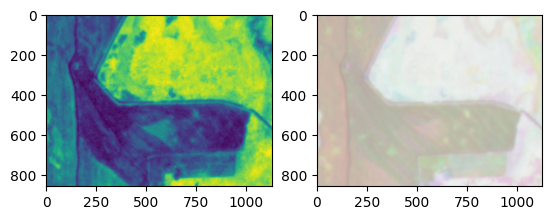

In [45]:
import matplotlib.pyplot as plt
import rasterio as rio

plt.figure()
f, axarr = plt.subplots(1,2)


with rio.open(os.path.join("/Users/orca/Documents/", rast)) as src:
    rast_arr = src.read(1)
axarr[0].imshow(rast_arr)
axarr[1].imshow(tiff_image)
plt.show()
     

In [ ]:
pred_tiff_path = os.path.join("/Users/orca/Documents/", rast.replace(".tif", "_pred.tif"))
sam_eo.tiff_to_tiff(rast, pred_tiff_path)
     

 50%|██████████████████████▌                      | 3/6 [04:31<04:31, 90.45s/it]

In [93]:
Map = geemap.Map()
point = ee.Geometry.Point(-122.259679, 37.871838)
collection = (
    ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterBounds(point)
    .filterDate("2008-01-01", "2018-01-01")
    .filter(ee.Filter.listContains("system:band_names", "N"))
)
image = collection.first()
Map.addLayer(image, {}, "NAIP")
Map.centerObject(point, 16)
Map
     

Map(center=[37.87183799999999, -122.259679], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

In [94]:
bbox = Map.user_roi_coords()
if bbox is None:
    bbox = [-122.2666, 37.8682, -122.252, 37.8752]

In [ ]:
geemap.ee_to_geotiff(
    image, "naip.tif", bbox, zoom=17, vis_params={"bands": ["R", "G", "B"]}
)

In [104]:

# Availble SamEO arguments:
# checkpoint="sam_vit_h_4b8939.pth",
# model_type='vit_h',
# device='cpu',
# erosion_kernel=(3, 3),
# mask_multiplier=255,
# sam_kwargs=None

# Availble sam_kwargs:
# points_per_side: Optional[int] = 32,
# points_per_batch: int = 64,
# pred_iou_thresh: float = 0.88,
# stability_score_thresh: float = 0.95,
# stability_score_offset: float = 1.0,
# box_nms_thresh: float = 0.7,
# crop_n_layers: int = 0,
# crop_nms_thresh: float = 0.7,
# crop_overlap_ratio: float = 512 / 1500,
# crop_n_points_downscale_factor: int = 1,
# point_grids: Optional[List[np.ndarray]] = None,
# min_mask_region_area: int = 0,
# output_mode: str = "binary_mask",

device = 'cuda:0'

sam_eo = SamEO(checkpoint="sam_vit_h_4b8939.pth",
               model_type='vit_h',
        #       device=device,
               erosion_kernel=(3, 3),
               mask_multiplier=255,
               sam_kwargs=None)
     

In [106]:

tms_source = 'https://tiles.openaerialmap.org/642385491a8878000512126c/0/642385491a8878000512126d/{z}/{x}/{y}'
pt1 = (29.676840, -95.369222)
pt2 = (29.678559, -95.367314)
zoom = 20
tms_tiff_path = 'test_tms_image.tif'

image = sam_eo.download_tms_as_tiff(tms_source, pt1, pt2, zoom, tms_tiff_path)

import cv2
tiff_image = cv2.cvtColor(cv2.imread(tms_tiff_path), cv2.COLOR_BGR2RGB)

42it [00:00, 115.50it/s]


<Figure size 640x480 with 0 Axes>

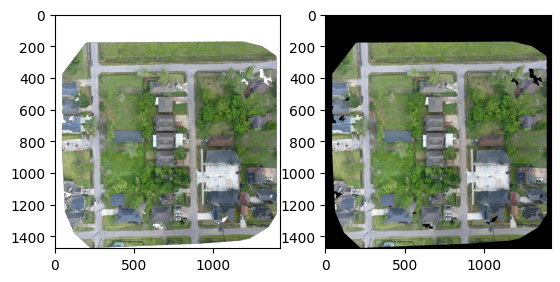

In [107]:
plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(tiff_image)
plt.show()
     

In [ ]:

pred_tiff_path = 'pred.tiff'
sam_eo.tiff_to_tiff(tms_tiff_path, pred_tiff_path)
     

 12%|█████▌                                      | 2/16 [02:50<19:55, 85.42s/it]

In [ ]:
pred_image = cv2.cvtColor(cv2.imread(pred_tiff_path), cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(pred_image)
plt.show()

In [ ]:

# Adjust simplification tolerance to reduce size (it could be bigger, than raster)
sam_eo.tiff_to_gpkg(pred_tiff_path, 'pred.gpkg', simplify_tolerance=None)

## 1) SAM

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

!git clone https://github.com/SysCV/sam-hq.git
!pip install timm
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth pretrained_checkpoint

In [ ]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_res(masks, scores, input_point, input_label, input_box, image):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        print(f"Score: {score:.3f}")
        plt.axis('off')
        plt.show()


def show_res_multi(masks, scores, input_point, input_label, input_box, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()


In [ ]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
import cv2

image =  cv2.cvtColor(cv2.imread(rast), cv2.COLOR_BGR2RGB)
input_box = np.array([[4,13,1007,1023]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)